In [56]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import time
from matplotlib.animation import FuncAnimation
from PIL import Image

class SpectrumEnvironment:
    def __init__(self, num_bands=10):
        self.num_bands = num_bands  # Total number of frequency bands
        self.channel_history = [[] for _ in range(num_bands)]  # Store states for each channel
        self.state = self._generate_spectrum_state()  # Current state of the spectrum
        self.total_reward = 0  # Track total reward
        self.rewards = []  # Track rewards for each step
        self.energy_costs = []


    def _generate_spectrum_state(self):
        """
        Generate a spectrum state that mimics a real environment.
        Each band can be idle (0) or occupied (1), with temporal dependencies.
        """
        # Temporal dependency weights for past states (e.g., decaying influence)
        temporal_weights = [0.5, 0.3, 0.2]  # Adjust these based on desired dependency
    
        # Generate new state based on channel history
        new_state = []
        for band in range(self.num_bands):
            # Retrieve recent history of the channel
            history = self.channel_history[band][-len(temporal_weights):]
    
            # Calculate the weighted influence of past states
            weighted_sum = sum(weight * state for weight, state in zip(temporal_weights, history[::-1]))
    
            # Apply a threshold to decide the next state
            threshold = 0.5  # Adjust for sensitivity
            base_probability = weighted_sum / sum(temporal_weights)
    
            # Add noise to simulate external interference
            noise = np.random.uniform(-0.1, 0.1)
    
            # Compute the final probability for being occupied (1)
            probability_occupied = min(max(base_probability + noise, 0), 1)
    
            # Determine the new state (1 = occupied, 0 = idle)
            new_state.append(1 if np.random.rand() < probability_occupied else 0)
    
        # Dynamically calculate busy hours using a sinusoidal function
        current_hour = int(time.time() // 3600) % 24  # Simulate hourly time slots
        activity_level = 0.5 + 0.5 * np.sin((2 * np.pi * current_hour) / 24)  # Activity ranges from 0 to 1
        busy_threshold = 0.7  # Threshold for busy hours
        if activity_level > busy_threshold:
            new_state = [1 if np.random.rand() < 0.6 else state for state in new_state]
    
        # Return the new state and update the history
        self.state = np.array(new_state)
        return self.state


    def energy_detection(self, band):
        """
        Simulates energy detection for a specific band.
        Considers energy consumption based on sensing history.
        """
        noise_level = random.uniform(0, 1)  # Simulate noise
        signal_level = random.uniform(0, 2) if self.state[band] == 1 else random.uniform(0, 0.5)
        detected_energy = signal_level + noise_level
        threshold = 1.0  # Energy threshold for detection
        
        # Energy consumption increases with history length
        sensing_history_length = len(self.channel_history[band])
        energy_consumption = 0.1 + 0.01 * sensing_history_length  # Base + history penalty
        return detected_energy < threshold, energy_consumption


    def matched_filter_fft(self, band):
        """
        Simulates matched filter detection using FFT.
        Considers higher energy consumption than energy detection.
        """
        signal_pattern = np.fft.fft(np.random.randn(10))  # Random pattern
        detected_signal = np.fft.fft(np.random.randn(10) + (self.state[band] * np.random.rand(10)))
        correlation = np.abs(np.dot(signal_pattern.conj(), detected_signal))
        threshold = 15  # Correlation threshold
        
        # Matched filtering has higher energy cost
        sensing_history_length = len(self.channel_history[band])
        energy_consumption = 0.2 + 0.02 * sensing_history_length  # Higher base + history penalty
        return correlation < threshold, energy_consumption


    def cyclostationary_detection(self, band):
        """
        Simulates cyclostationary feature detection for periodic properties.
        Has moderate energy consumption.
        """
        periodic_property = random.uniform(0, 1) if self.state[band] == 0 else random.uniform(0.5, 1.5)
        threshold = 0.7
    
        # Cyclostationary detection consumes moderate energy
        sensing_history_length = len(self.channel_history[band])
        energy_consumption = 0.15 + 0.015 * sensing_history_length  # Moderate base + history penalty
        return periodic_property < threshold, energy_consumption


    def step(self, action, method="ED"):
        """
        Simulate sensing a specific band with advanced detection techniques.
        Deduct energy consumption from the reward.
        """
        reward = 0
    
        # Call the appropriate detection method
        if method == "ED":
            hole_detected, energy_consumption = self.energy_detection(action)
        elif method == "C":
            hole_detected, energy_consumption = self.cyclostationary_detection(action)
        elif method == "MF":
            hole_detected, energy_consumption = self.matched_filter_fft(action)
        else:
            raise ValueError("Invalid detection method")
        
        self.energy_costs.append(energy_consumption)
        # Reward for sensing
        if hole_detected and self.state[action] == 0:
            reward = 30
        elif not hole_detected and self.state[action] == 1:
            reward = 5
        else:
            reward = -15
    
        # Deduct energy consumption penalty
        reward -= energy_consumption * 10  # Scale energy cost penalty
    
        self.total_reward += reward
        self.rewards.append(reward)
    
        # Record the current state in the history
        for i in range(self.num_bands):
            self.channel_history[i].append(self.state[i])
    
        # Randomize the spectrum state for the next step
        self.state = self._generate_spectrum_state()
        return self.state, reward

    def reset(self):
        """Reset the environment to an initial state."""
        self.state = self._generate_spectrum_state()
        self.total_reward = 0
        self.rewards = []
        return self.state
    



Animation saved as channel_states.gif


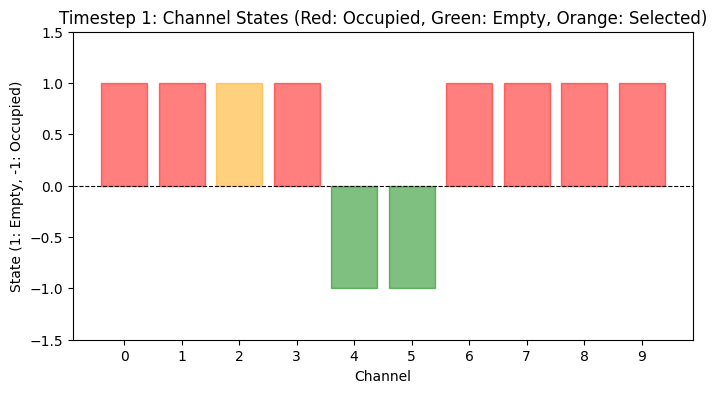

In [57]:
# Initialize the environment
env = SpectrumEnvironment(num_bands=10)

# Initialize variables for testing
steps = 50
selected_bands = np.random.choice(range(env.num_bands), steps, replace=True)
states_over_time = []
actions_over_time = []

# Run the environment over 10 steps
for step in range(steps):
    selected_band = selected_bands[step]
    actions_over_time.append(selected_band)
    state, reward = env.step(selected_band)
    states_over_time.append(state)
    
# env.reset()
# Visualization
# Initialize figure
fig, ax = plt.subplots(figsize=(8, 4))

# Animation setup
bars = ax.bar(range(env.num_bands), [0] * env.num_bands, color='gray', alpha=0.5, edgecolor='black', linewidth=1)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_ylim(-1.5, 1.5)
ax.set_xticks(range(env.num_bands))
ax.set_xlabel("Channel")
ax.set_ylabel("State (1: Empty, -1: Occupied)")
ax.set_title("Channel States Over Time")

# Update function for animation
def update(step):
    ax.set_title(f"Timestep {step + 1}: Channel States (Red: Occupied, Green: Empty, Orange: Selected)")
    state = states_over_time[step]
    action = actions_over_time[step]
    for band, bar in enumerate(bars):
        y = -1 if state[band] == 0 else 1
        color = 'green' if state[band] == 0 else 'red'
        if band == action:
            color = 'orange'
        bar.set_height(y)
        bar.set_color(color)

# Create animation
anim = FuncAnimation(fig, update, frames=steps, interval=200)

# Save animation as .gif
gif_path = "channel_states.gif"
anim.save(gif_path, writer="pillow")
print(f"Animation saved as {gif_path}")

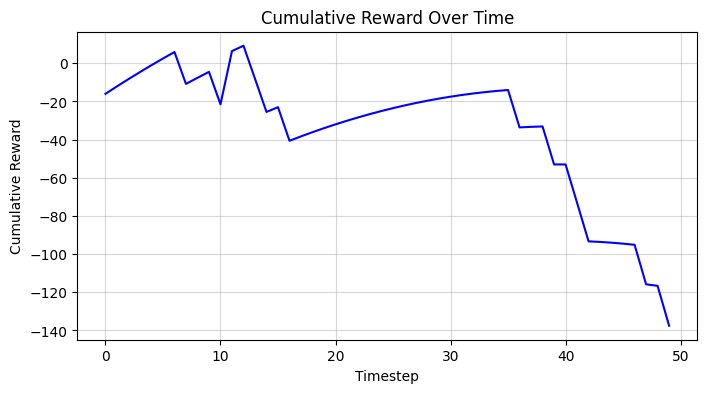

In [58]:
# Calculate cumulative reward
cumulative_rewards = np.cumsum(env.rewards)

# Plot cumulative reward
plt.figure(figsize=(8, 4))
plt.plot(range(steps), cumulative_rewards,linestyle='-', color='blue')
plt.title("Cumulative Reward Over Time")
plt.xlabel("Timestep")
plt.ylabel("Cumulative Reward")
plt.grid(alpha=0.5)
plt.show()


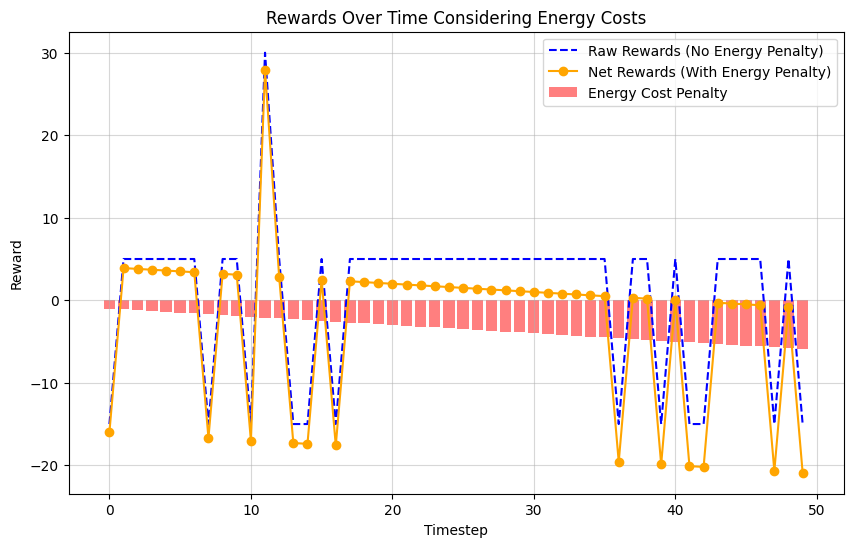

In [59]:
# Example reward comparison with energy costs
raw_rewards = [r + energy * 10 for r, energy in zip(env.rewards, env.energy_costs)]  # Without penalty
net_rewards = env.rewards  # With penalty

plt.figure(figsize=(10, 6))
plt.plot(range(len(raw_rewards)), raw_rewards, label="Raw Rewards (No Energy Penalty)", linestyle="--", color="blue")
plt.plot(range(len(net_rewards)), net_rewards, label="Net Rewards (With Energy Penalty)", marker="o", color="orange")
plt.bar(range(len(env.energy_costs)), [-e * 10 for e in env.energy_costs], label="Energy Cost Penalty", alpha=0.5, color="red")
plt.title("Rewards Over Time Considering Energy Costs")
plt.xlabel("Timestep")
plt.ylabel("Reward")
plt.legend()
plt.grid(alpha=0.5)
plt.show()


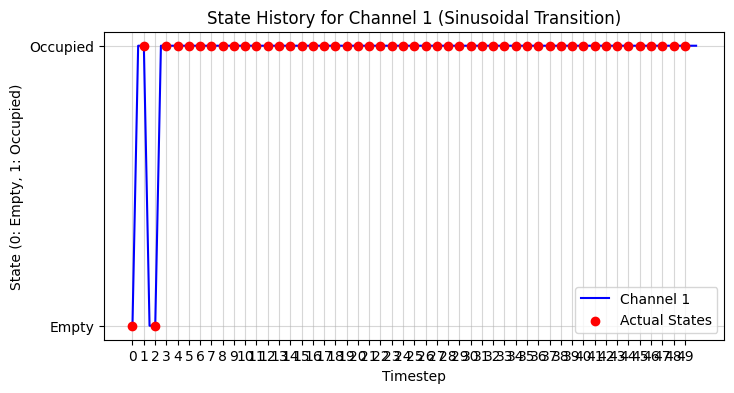

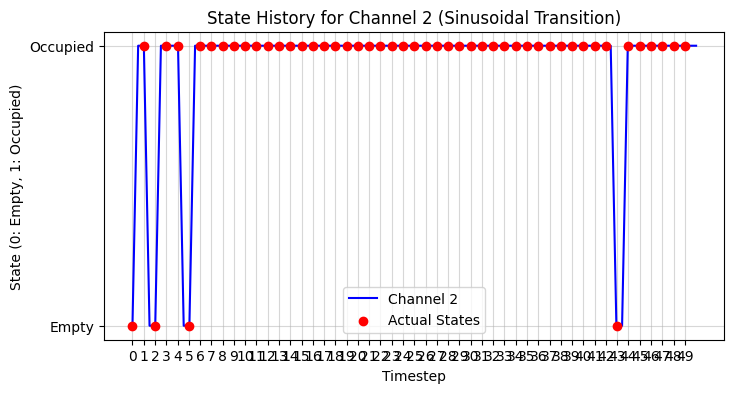

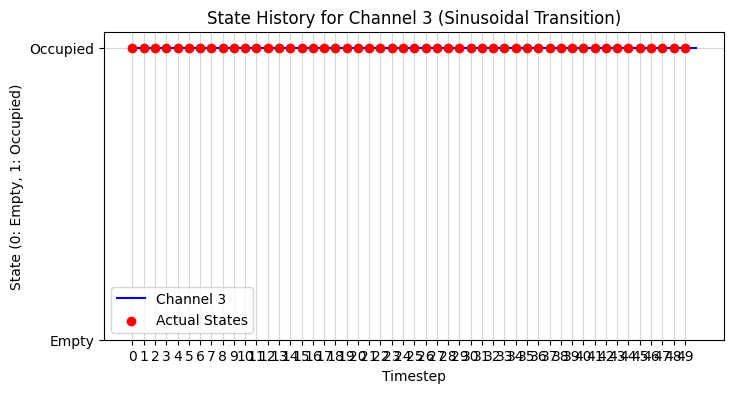

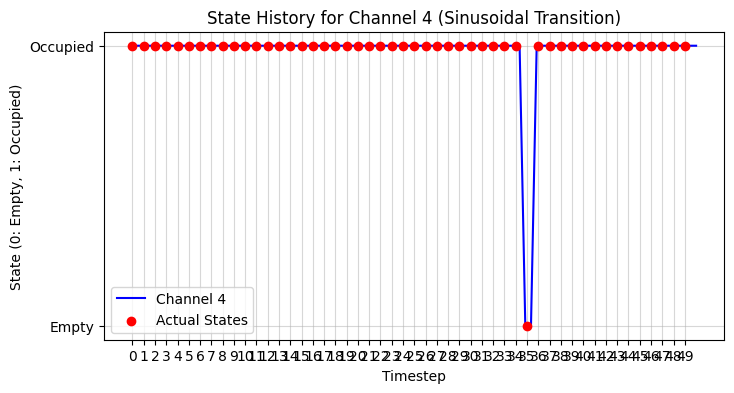

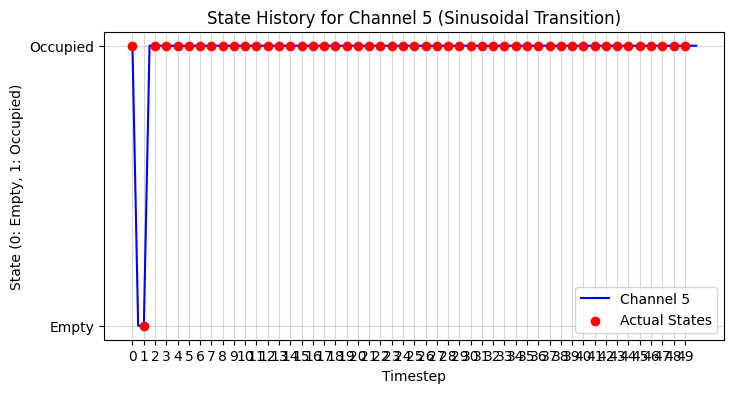

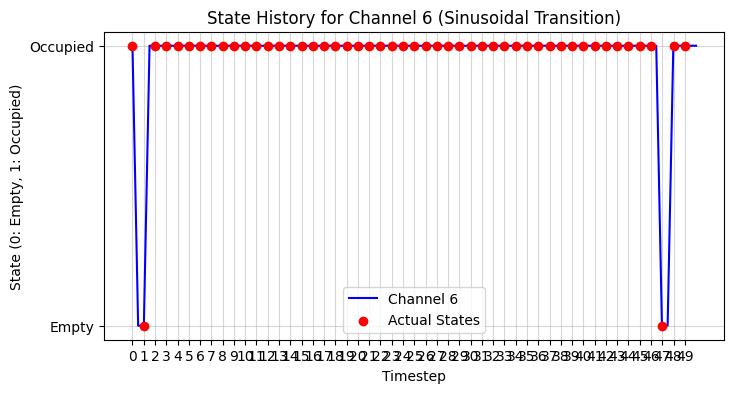

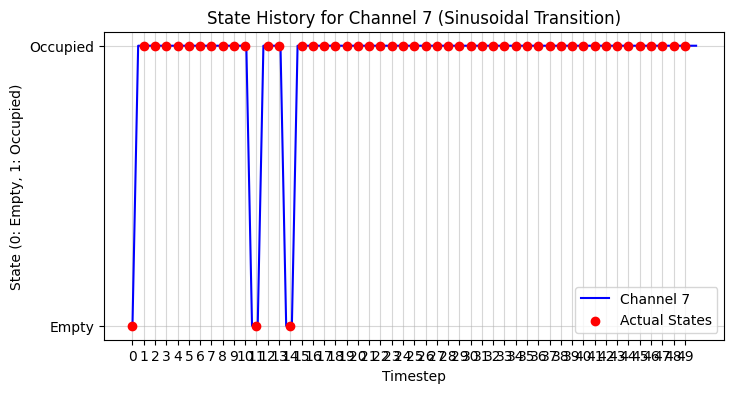

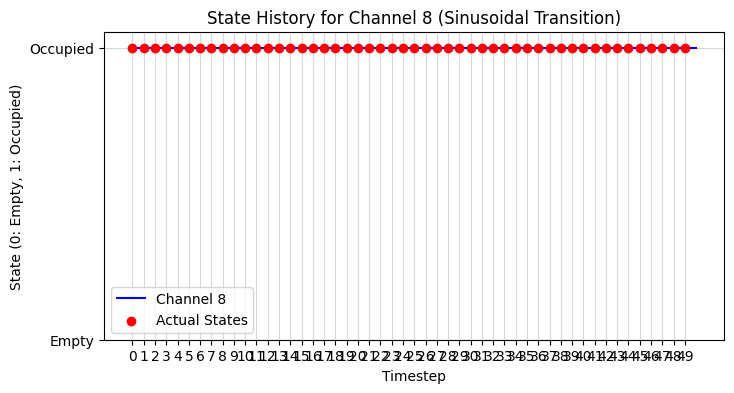

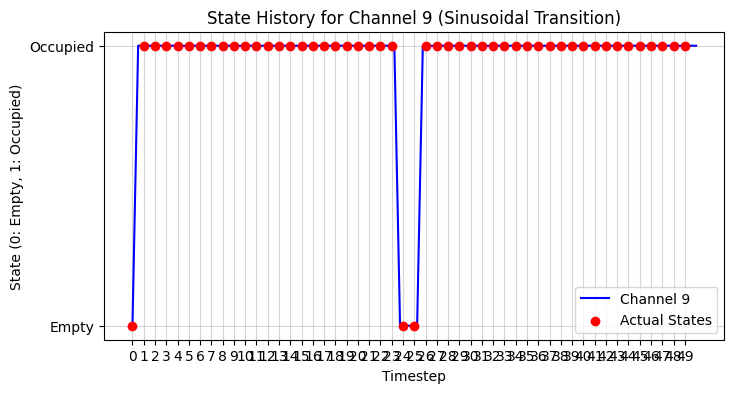

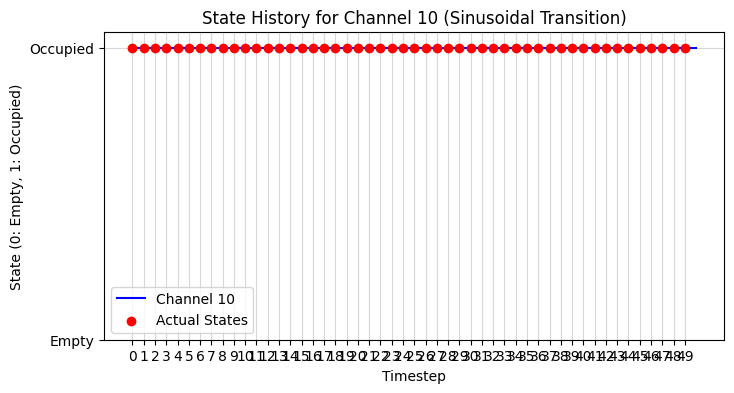

In [60]:
# Visualization with sinusoidal transitions
time_per_step = 2  # Number of points per step for smooth transitions
total_points = steps * time_per_step  # Total points for the plot

for band, history in enumerate(env.channel_history):
    plt.figure(figsize=(8, 4))

    # Generate sinusoidal transitions
    x_points = np.linspace(0, steps, total_points)
    y_points = []
    for i in range(len(history[:steps])):
        start = history[i]
        end = history[i + 1] if i + 1 < len(history) else history[i]
        t = np.linspace(0, 1, time_per_step)
        y_points.extend(start + (end - start) * 0.5 * (1 - np.cos(np.pi * t)))

    # Plot the sinusoidal curve
    plt.plot(x_points, y_points, label=f"Channel {band + 1}", marker=None, color='blue')

    # Add step markers for actual states
    plt.scatter(range(steps), history[:steps], color='red', zorder=5, label="Actual States")

    plt.title(f"State History for Channel {band + 1} (Sinusoidal Transition)")
    plt.xlabel("Timestep")
    plt.ylabel("State (0: Empty, 1: Occupied)")
    plt.xticks(range(steps))
    plt.yticks([0, 1], labels=["Empty", "Occupied"])
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()
